<h1><center>DataGym</center></h1>
<h3><center>Григорий Хомюк</center></h3>
<hr>
<h2><center>Курсовая работа</center></h2>
<h2><center>Pump it Up: Data Mining the Water Table<center></h2> 

![Alt text](https://disk.yandex.ru/i/9rMkVbiVwpnAUw)

Данная работа основана на соревновании: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/


### Задача: используя данные Таарифы и Министерства водного хозяйства Танзании, предсказать, какие водяные насосы работают, какие требуют ремонта, а какие вообще не работают?
 

##### Метрика качества:  accuracy 

### data description:

`amount_tsh` - Total static head (amount water available to waterpoint)

`date_recorded` - The date the row was entered

`funder` - Who funded the well

`gps_height` - Altitude of the well

`installer` - Organization that installed the well

`longitude` - GPS coordinate

`latitude` - GPS coordinate

`wpt_name` - Name of the waterpoint if there is one

`num_private` -

`basin` - Geographic water basin

`subvillage` - Geographic location

`region` - Geographic location

`region_code` - Geographic location (coded)

`district_code` - Geographic location (coded)

`lga` - Geographic location

`ward` - Geographic location

`population` - Population around the well

`public_meeting` - True/False

`recorded_by` - Group entering this row of data

`scheme_management` - Who operates the waterpoint

`scheme_name` - Who operates the waterpoint

`permit` - If the waterpoint is permitted

`construction_year` - Year the waterpoint was constructed

`extraction_type` - The kind of extraction the waterpoint uses

`extraction_type_group` - The kind of extraction the waterpoint uses

`extraction_type_class` - The kind of extraction the waterpoint uses

`management` - How the waterpoint is managed

`management_group` - How the waterpoint is managed

`payment` - What the water costs

`payment_type` - What the water costs

`water_quality` - The quality of the water

`quality_group` - The quality of the water

`quantity` - The quantity of water

`quantity_group` - The quantity of water

`source` - The source of the water

`source_type` - The source of the water

`source_class` - The source of the water

`waterpoint_type` - The kind of waterpoint

`waterpoint_type_group` - The kind of waterpoint


<h2> Import libraries </h2> 

In [672]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
import datetime
from datetime import datetime
from numpy import nan
import seaborn as sns
import matplotlib
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import random
from sklearn.feature_selection import RFECV, RFE
import pygeohash as gh
from vecstack import stacking
from sklearn.ensemble import BaggingClassifier

<h2>EDA</h2> 

In [2]:
test = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv', sep=',')

In [3]:
train = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv', sep=',')

In [4]:
labels = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv', sep=',')

In [5]:
y_train = labels['status_group']

Для удобства объединим тестовую и обучающую выборку в один датасет: создав колонку **sample**, которая принимает два значения: test и train.

In [6]:
train['sample'] = 'train'
test['sample'] = 'test'

In [7]:
df = train.append(test).reset_index(drop=True)

Посмотрим на данные:

In [9]:
y_train

0            functional
1            functional
2            functional
3        non functional
4            functional
              ...      
59395        functional
59396        functional
59397        functional
59398        functional
59399        functional
Name: status_group, Length: 59400, dtype: object

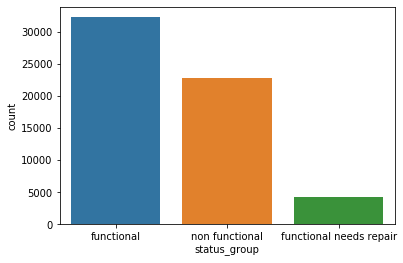

In [11]:
sns.countplot(y_train);

In [ ]:
#df[‘c’].value_counts() 

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 41 columns):
id                       74250 non-null int64
amount_tsh               74250 non-null float64
date_recorded            74250 non-null object
funder                   69746 non-null object
gps_height               74250 non-null int64
installer                69718 non-null object
longitude                74250 non-null float64
latitude                 74250 non-null float64
wpt_name                 74250 non-null object
num_private              74250 non-null int64
basin                    74250 non-null object
subvillage               73780 non-null object
region                   74250 non-null object
region_code              74250 non-null int64
district_code            74250 non-null int64
lga                      74250 non-null object
ward                     74250 non-null object
population               74250 non-null int64
public_meeting           70095 non-null object
r

In [13]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [14]:
df.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    4504
gps_height                   0
installer                 4532
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 470
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            4155
recorded_by                  0
scheme_management         4846
scheme_name              35258
permit                    3793
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [15]:
# уникальные значения
columns_names = df.columns.to_list()
for i in range(len(df.T)):
    print (columns_names[i], ":", len(df[columns_names[i]].unique()))

id : 74250
amount_tsh : 102
date_recorded : 369
funder : 2141
gps_height : 2456
installer : 2411
longitude : 71870
latitude : 71869
wpt_name : 45684
num_private : 68
basin : 9
subvillage : 21426
region : 21
region_code : 27
district_code : 20
lga : 125
ward : 2098
population : 1128
public_meeting : 3
recorded_by : 1
scheme_management : 13
scheme_name : 2869
permit : 3
construction_year : 55
extraction_type : 18
extraction_type_group : 13
extraction_type_class : 7
management : 12
management_group : 5
payment : 7
payment_type : 7
water_quality : 8
quality_group : 6
quantity : 5
quantity_group : 5
source : 10
source_type : 7
source_class : 3
waterpoint_type : 7
waterpoint_type_group : 6
sample : 2


По вышеописанным статистикам, заметим, что `recorded_by` имеет одно уникальное значение. Следовательно, эта фича под удаление.

`wpt_name` имеет 45 тысяч уникальных значений – удаляем.

In [16]:
df['num_private'].unique()

array([   0,   39,    5,   45,    6,    3,  698,   32,   15,    7,   25,
        102,    1,   93,   14,   34,  120,   17,  213,   47,    8,   41,
         80,  141,   20,   35,  131,    4,   22,   11,   87,   61,   65,
        136,    2,  180,   38,   62,    9,   16,   23,   42,   24,   12,
        668,  672,   58,  150,  280,  160,   50, 1776,   30,   27,   10,
         94,   26,  450,  240,  755,   60,  111,  300,   55, 1402,  669,
         13,  420])

In [17]:
len(df[
    (df['num_private'] == 0)
])

73299

Признак `num_private` тоже под удаление, 99% данных имеют значение 0 в этой колонке.

In [18]:
df[(df['subvillage'] == 'Nyamara')]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,sample
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train
2755,45674,0.0,2013-03-06,Government Of Tanzania,1399,Government,34.698453,-2.146846,Zahanati,0,...,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,train
12140,42312,0.0,2013-03-06,Government Of Tanzania,1399,Government,34.689976,-2.150565,Nyangi Sirocha,4,...,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,train
24536,60932,0.0,2013-03-06,Government Of Tanzania,1399,Government,34.692130,-2.146960,Juma Hassan,5,...,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,train
50047,12039,0.0,2013-03-06,Government Of Tanzania,1396,Government,34.696046,-2.151478,Machota,0,...,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,train
60922,25325,0.0,2013-03-06,Government Of Tanzania,1397,Government,34.690275,-2.147671,Omarry Nyambureti,0,...,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,test


In [19]:
# заметим закономерность 
example = train.join(y_train)
example[(example['subvillage'] == 'Nyamara')]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,sample,status_group
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train,functional
2755,45674,0.0,2013-03-06,Government Of Tanzania,1399,Government,34.698453,-2.146846,Zahanati,0,...,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,train,functional
12140,42312,0.0,2013-03-06,Government Of Tanzania,1399,Government,34.689976,-2.150565,Nyangi Sirocha,4,...,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,train,functional
24536,60932,0.0,2013-03-06,Government Of Tanzania,1399,Government,34.692130,-2.146960,Juma Hassan,5,...,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,train,functional
50047,12039,0.0,2013-03-06,Government Of Tanzania,1396,Government,34.696046,-2.151478,Machota,0,...,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,train,functional


Признак `subvillage` имеет очень много уникальных значений (21426) и применять к нему **one_hot_encoding** не резонно, но мы попробуем выжать максимум из данных. В дальнейшем, мы удалим неинформативные признаки. 

В фичах с пропущенными значениями мы сделаем отдельную категорию _"my_uniq_na"_.

# Feature Engineering

`date_recorded` – дата проверки водяного насоса на пригодность, а `construction_year` – год постройки. Из этих двух фичей можно сделать новую –> `age`, которая будет отвечать за срок службы объекта. Для такой процедуры напишем специальную функцию, которой передаётся значения признаков, а возвращаемое значение = количество прослуженных лет.

In [20]:
def age(year1, year2):
    recorded_year = datetime.strptime(year1, '%Y-%m-%d').date()
    record = recorded_year.year
    if year2 == 0: 
        return nan
    else: 
        return record - year2

Используя долготу и широту (`longitude`, `latitude`) создадим фичу `geohash`, которая будет отвечать также за географическое расположение объекта. Обрезав значение геохэша до трех знаков, получим около 50 уникальных значений для последующего **one_hot_encoding'a**.

In [21]:
# обрезает строку 
def cuter(s):
    return s[0:3]

# Function for Preprocessing

Для удобства напишем специальную функцию для предобработки, в которой будут включены все действия над данными:

In [22]:
def data_preprocessing(df_input):
    df = df_input.copy()
    #df.reset_index(inplace=True)
    
    df['age'] = df.apply(lambda x: age(x['date_recorded'], x['construction_year']), axis= 1)
    df['age'] = df['age'].fillna(df['age'].mean())
    
    df.drop(columns = ['date_recorded', 'construction_year', 'wpt_name', 'num_private',
                       'recorded_by'], inplace=True)
    
    df['geohash'] = df.apply(lambda x : 
                             gh.encode(x.latitude, x.longitude, precision=5), axis=1)
    df['geohash'] = df['geohash'].map(cuter)
    
    numeric_cols = ['amount_tsh', 'gps_height', 'longitude',
                    'latitude', 'population', 'age']
    
    categorical_cols = list(set(df.columns.values.tolist()) - set(numeric_cols))
    
    
    #categorical_cols.append('region_code')
    #categorical_cols.append('district_code')
    
    categorical_cols.remove('id')
    
    categorical_cols.remove('sample')
    
    
    #for i in range(len(categorical_cols)):
        #print (categorical_cols[i])
    
    X_cat = (df[categorical_cols]).fillna('my_uniq_na')
    X_cat = X_cat.astype(str)
    
    one_hot = pd.get_dummies(X_cat)
    df = df.drop(categorical_cols,axis = 1)
    df = df.join(one_hot)
    
    return df

Эта функция возвращает датафрейм с удалёнными `date_recorded`, `construction_year`, `wpt_name`, `num_private`, `recorded_by` ; с новыми `age` и `geohash` ; ко всем категориальным признакам применяется метод **one_hot_encoding**, а пропущенные значения в таких признаках заменяются на уникальную категорию _"my_uniq"_ ;

In [23]:
df_new = df.pipe(data_preprocessing)

In [24]:
df_new.head(5)

,id,amount_tsh,gps_height,longitude,latitude,population,sample,age,basin_Internal,basin_Lake Nyasa,...,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown
0,69572,6000.0,1390,34.938093,-9.856322,109,train,12.000000,0,1,...,0,0,0,0,1,0,1,0,0,0
1,8776,0.0,1399,34.698766,-2.147466,280,train,3.000000,0,0,...,0,1,0,0,0,0,0,1,0,0
2,34310,25.0,686,37.460664,-3.821329,250,train,4.000000,0,0,...,0,0,0,0,0,0,1,0,0,0
3,67743,0.0,263,38.486161,-11.155298,58,train,27.000000,0,0,...,0,0,0,0,0,1,0,0,0,0
4,19728,0.0,0,31.130847,-1.825359,0,train,15.295624,0,0,...,0,1,0,0,0,0,0,0,1,0


Следующий код изменяет названия колонок в датафрейме на правильные: убирает некоторые символы _"[ , ] < $"_ . Это необходимо для обучения **xgboost**.

In [25]:
mylist = df_new.columns.values.tolist()

def change_col(mylist):
    dictionary = dict()
    arr = ['[', ',', ']', '<', '$']
    for i in range(len(mylist)):
        key = mylist[i]
        name = mylist[i]
        for x in arr:
            name = name.replace(x, "__")
        dictionary[key] = name
    return dictionary

dictionary = change_col(mylist)
df_new.rename(columns = dictionary, inplace=True)

Отделим обучение и тест:

In [26]:
train = df_new[df_new['sample']=='train'].drop(columns='sample')
test = df_new[df_new['sample']=='test'].drop(columns='sample')

По итогу, получилось 31354 признаков.

In [27]:
len(train.T)

31355

In [28]:
X_train = train[train.columns[1:]]

In [29]:
len(X_train.T)

31354

# Feature Selection

На примере модели градиентного бустинга отберём информативные признаки для дальнейшего обучения моделей, воспользовавшись атрибутом `feature_importances_`. Обучим `XGBClassifier` с параметрами по умолчанию, на всех признаках:

In [36]:
model = XGBClassifier()

In [37]:
model.fit(X_train, y_train)
# feature importance
print(model.feature_importances_)

[0.0148682  0.00307455 0.00594026 ... 0.         0.         0.        ]


Создадим список фичей, которые имеют показатель информативности не равный нулю, а также запишем в файл этот список:

In [41]:
mycolumns = X_train.columns.values.tolist()
imp_feat = []
dictionary2 = dict()
for i in range(len(model.feature_importances_)):
    if model.feature_importances_[i] != 0:
        value = model.feature_importances_[i]
        key = mycolumns[i]
        dictionary2[key] = value
        imp_feat.append(key)
        print(key, value)

amount_tsh 0.014868195
gps_height 0.003074548
longitude 0.005940264
latitude 0.0022264908
population 0.0016235099
age 0.015179689
district_code_1 0.0032024395
district_code_2 0.0014591052
district_code_30 0.008233742
district_code_33 0.0037260007
district_code_4 0.0052943276
district_code_53 0.0034404695
district_code_7 0.0012771556
quality_group_good 0.0010468911
quality_group_milky 0.003082327
quality_group_unknown 0.007608568
quantity_group_dry 0.05733152
quantity_group_enough 0.015393305
quantity_group_insufficient 0.0011542039
quantity_group_seasonal 8.8245106e-05
quantity_group_unknown 0.006565856
public_meeting_False 0.005753471
public_meeting_True 0.0066441256
public_meeting_my_uniq_na 0.0037100248
extraction_type_group_afridev 0.002094489
extraction_type_group_gravity 0.0077275173
extraction_type_group_india mark ii 0.00065714936
extraction_type_group_nira/tanira 0.0062402952
extraction_type_group_other 0.038367353
extraction_type_group_other handpump 0.0009227671
extraction_t

In [57]:
# сохранить фичи в файл
features = pd.DataFrame.from_dict(dictionary2, orient='index')
features.reset_index(level=0, inplace=True)
col_names = ['feature', 'importance']
features.columns = col_names

In [58]:
features.head(3)

,feature,importance
0,amount_tsh,0.014868
1,gps_height,0.003075
2,longitude,0.005940


In [59]:
features_csv = pd.DataFrame(zip(features['feature'], features['importance']), 
                    columns = ['feature', 'importance']).to_csv('importance_features.csv',
                                                                  sep=',',
                                                                  index=False)

In [46]:
# открытие файла
imp_f = pd.read_csv('importance_features.csv', sep=',')
imp_feat = imp_f['feature'].to_list()

Из 31354 отобрали 233 признака:

In [47]:
print(len(imp_feat))

233


Сравним качество бустинга, обученного на всём признаковом пространстве, с обученным только на информативных признаках: 

In [53]:
xgb = XGBClassifier()

In [54]:
X_small = X_train[:2000]
y_small = y_train[:2000]

In [56]:
print(cross_val_score(xgb, X_small[imp_feat], y_small, scoring = 'accuracy', cv=3).mean())

0.7239983611797705


In [57]:
print(cross_val_score(xgb, X_small, y_small, scoring = 'accuracy', cv=3).mean())

0.7215003609306457


Сделаем вывод, что обучать модель на всех признаках неэффективно. Эффективнее отобрать информативные признаки и обучаться только на них.

А теперь начнём обучать модели на новом признаковом пространстве: 

In [485]:
X_train

,amount_tsh,gps_height,longitude,latitude,population,age,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,...,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown
0,6000.0,1390,34.938093,-9.856322,109,12.000000,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0.0,1399,34.698766,-2.147466,280,3.000000,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,25.0,686,37.460664,-3.821329,250,4.000000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,263,38.486161,-11.155298,58,27.000000,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,0,31.130847,-1.825359,0,15.295624,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,1210,37.169807,-3.253847,125,14.000000,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
59396,4700.0,1212,35.249991,-9.070629,56,15.000000,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
59397,0.0,0,34.017087,-8.750434,0,15.295624,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
59398,0.0,0,35.861315,-6.378573,0,15.295624,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [543]:
X_tr = X_train[imp_feat]

И закодируем наш таргет с помощью LabelEncoder():

In [730]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [731]:
y_TR = le.transform(y_train)
print (y_TR[:7], le.classes_)
#le.inverse_transform([0, 0, 1, 2])

[0 0 0 2 0 0 2] ['functional' 'functional needs repair' 'non functional']


---

# 1 Level: XGBoosting 

Создадим пайплайн с нашей моделью, а также добавим нормирование данных на первом шаге:

In [59]:
mypipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])

С помощью `RandomizedSearchCV` выполним перебор параметров на кроссвалидации, чтобы "выловить" наилучшие параметры:

In [83]:
param_test1 = {
    'xgb__n_estimators' : range(88, 100, 2),
    'xgb__max_depth' : range(13, 30, 2),
    'xgb__min_child_weight' : range(1, 3, 1),
    
    'xgb__gamma' : [num / 10 for num in range(5, 9, 1)],
    'xgb__subsample' : [(num + 5) / 10 for num in range(4, 6, 1)],
    'xgb__colsample_bytree' : [(num + 5) / 10 for num in range(0, 3, 1)]
}

In [84]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

hyper_search = RandomizedSearchCV(mypipeline2, param_test1, n_iter=10, scoring='accuracy', 
                                  cv=cv, n_jobs=-1, refit=True, random_state=123,
                                  verbose=2)
hyper_search.fit(X_tr, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/gregor/anaconda2/envs/ipykernel_py3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 112.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 149.5min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('xgb',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=1,
                                                            gamma=0,
              

In [85]:
hyper_search.best_params_

{'xgb__subsample': 0.9,
 'xgb__n_estimators': 90,
 'xgb__min_child_weight': 1,
 'xgb__max_depth': 17,
 'xgb__gamma': 0.7,
 'xgb__colsample_bytree': 0.6}

In [86]:
hyper_search.best_score_

0.8151178451178451

In [87]:
best_model_xgb = hyper_search.best_estimator_

# 1 Level: Random Forest 

Обучим следующую модель – случайный лес; И найдём лучшие параметры для неё:

In [120]:
mypipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('forest', RandomForestClassifier())
])

In [130]:
param_grid_base = {
              'forest__n_estimators': range(90, 100),
              'forest__min_samples_split': range(4, 7),
              'forest__min_samples_leaf': [1],
              'forest__max_features': range(18, 26),
              'forest__max_depth': range(28, 36) }

In [131]:
hyper_search = RandomizedSearchCV(mypipeline, param_grid_base, n_iter=30, scoring='accuracy', 
                                  cv=cv, n_jobs=-1, refit=True, random_state=123,
                                  verbose=2)
hyper_search.fit(X_tr, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 22.3min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('forest',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                        

In [132]:
hyper_search.best_params_

{'forest__n_estimators': 94,
 'forest__min_samples_split': 5,
 'forest__min_samples_leaf': 1,
 'forest__max_features': 20,
 'forest__max_depth': 30}

In [133]:
hyper_search.best_score_

0.813989898989899

In [135]:
best_model_rf = hyper_search.best_estimator_

# 1 Level: KNN 

Следующая модель: KNN

In [305]:
mypipeknn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [316]:
paramknn = {
    'knn__n_neighbors': range(18, 26, 1),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'chebyshev', 'manhattan', 'canberra'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

In [317]:
hyper_search = RandomizedSearchCV(mypipeknn, paramknn, n_iter=10, scoring='accuracy', 
                                  cv=cv, n_jobs=3, refit=True, random_state=123,
                                  verbose=2)
hyper_search.fit(X_tr, y_TR)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 57.5min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed: 85.0min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('knn',
                                              KNeighborsClassifier(algorithm='auto',
                                                                   leaf_size=30,
                                                                   metric='minkowski',
                                                                   metric_params=None,
                                                                   n_jobs=None,
                                                          

In [318]:
hyper_search.best_params_

{'knn__weights': 'distance',
 'knn__n_neighbors': 20,
 'knn__metric': 'canberra',
 'knn__algorithm': 'brute'}

In [319]:
hyper_search.best_score_

0.7912289562289563

In [330]:
paramknn2 = {
    'knn__n_neighbors': range(16, 23, 1),
    'knn__weights': ['distance'],
    'knn__metric': ['canberra'],
    'knn__algorithm': ['auto'],
}

In [331]:
hyper_search = RandomizedSearchCV(mypipeknn, paramknn2, n_iter=5, scoring='accuracy', 
                                  cv=cv, n_jobs=3, refit=True, random_state=123,
                                  verbose=2)
hyper_search.fit(X_tr, y_TR)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed: 102.1min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('knn',
                                              KNeighborsClassifier(algorithm='auto',
                                                                   leaf_size=30,
                                                                   metric='minkowski',
                                                                   metric_params=None,
                                                                   n_jobs=None,
                                                          

In [334]:
hyper_search.best_params_

{'knn__weights': 'distance',
 'knn__n_neighbors': 17,
 'knn__metric': 'canberra',
 'knn__algorithm': 'auto'}

In [335]:
hyper_search.best_score_

0.791952861952862

In [336]:
best_model_knn = hyper_search.best_estimator_ # 0.8006

Далее воспользуемся библиотекой `vecstack` для создания многоуровневой модели. Используя ответы разных моделей как фичи, мы можем повысить качество классификации.

# Stacking

In [538]:
X_test = test[test.columns[1:]]
X_te = X_test[imp_feat]

In [337]:
models = [
    best_model_rf,
    best_model_xgb,
    best_model_knn,
]

In [345]:
S_train, S_test = stacking(models,                     # list of models
                           X_tr, y_TR, X_te,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           mode='oof_pred_bag',        # mode: oof for train set, predict test 
                                                       #     set in each fold and vote
                           needs_proba=False,          # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric=accuracy_score,      # metric: callable
                           n_folds=5,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=True,               # shuffle the data
                           random_state=123,             # ensure reproducibility
                           verbose=2)                  # print all info

task:         [classification]
n_classes:    [3]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [Pipeline]
    fold  0:  [0.81634543]
    fold  1:  [0.81567208]
    fold  2:  [0.81254209]
    fold  3:  [0.81161616]
    fold  4:  [0.80897457]
    ----
    MEAN:     [0.81303007] + [0.00270762]
    FULL:     [0.81303030]

model  1:     [Pipeline]
    fold  0:  [0.82240552]
    fold  1:  [0.81701877]
    fold  2:  [0.81582492]
    fold  3:  [0.81144781]
    fold  4:  [0.80889039]
    ----
    MEAN:     [0.81511748] + [0.00467919]
    FULL:     [0.81511785]

model  2:     [Pipeline]
    fold  0:  [0.79648178]
    fold  1:  [0.79395674]
    fold  2:  [0.79132997]
    fold  3:  [0.79065657]
    fold  4:  [0.78733794]
    ----
    MEAN:     [0.79195260] + [0.00309492]
    FULL:     [0.79195286]



In [548]:
TRAIN = X_tr.copy()
TRAIN['rf'] = S_train[:, 0]
TRAIN['xgb'] = S_train[:, 1]
TRAIN['knn'] = S_train[:, 2]

TEST = X_te.copy()
TEST['rf'] = S_test[:, 0]
TEST['xgb'] = S_test[:, 1]
TEST['knn'] = S_test[:, 2]

На данном этапе мы имеем ответы всех трёх моделей, которые находятся в `S_train` и `S_test`.

# 2 Level: Random Forest

![texte](model.jpg)

Обучим случайный лес на ответах предыдущих трёх моделей и на нашем признаковом пространстве. Найдём наилучшие параметры.

In [589]:
mypipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('forest', RandomForestClassifier())
])

In [590]:
param_grid_base = {
              'forest__n_estimators': range(80, 120, 2),
              'forest__min_samples_split': range(3, 7),
              'forest__min_samples_leaf': [1, 2, 3],
              'forest__max_features': range(13, 28),
              'forest__max_depth': range(20, 40) }

In [591]:
hyper_search = RandomizedSearchCV(mypipeline, param_grid_base, n_iter=10, scoring='accuracy', 
                                  cv=cv, n_jobs=-1, refit=True, random_state=123,
                                  verbose=2)
hyper_search.fit(TRAIN, y_TR)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.5min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('forest',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                        

In [592]:
hyper_search.best_params_

{'forest__n_estimators': 114,
 'forest__min_samples_split': 3,
 'forest__min_samples_leaf': 1,
 'forest__max_features': 17,
 'forest__max_depth': 24}

In [593]:
hyper_search.best_score_  

0.8204040404040404

In [594]:
best_model_stack_rf = hyper_search.best_estimator_ 

# Predictions

Записываем прогнозы модели в `.csv` файл и проверяем на тесте:

In [729]:
y_hat = best_model_stack_rf.predict(TEST)
y_pred = le.inverse_transform(y_hat)
data = pd.DataFrame(zip(test['id'], y_pred), 
                    columns = ['id', 'status_group']).to_csv('final_prediction.csv',
                                                                  sep=',',
                                                                  index=False)

# Rank

![texte](rate.jpg)

---